In [167]:
# モジュールのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold

import catboost as cb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split


# data_road
train_data = pd.read_csv("../data/train.tsv", delimiter='\t')
test_data = pd.read_csv("../data/test.tsv", delimiter='\t')
x, y = train_data.drop(['LeagueIndex', 'Unnamed: 0', 'GameID'], axis=1), train_data["LeagueIndex"]-1
test_x = test_data.drop(['Unnamed: 0', 'GameID'], axis=1)

x['a'] = x['TotalHours'] / x['HoursPerWeek']
# x.drop(['APM','SelectByHotkeys', 'ActionLatency'], axis=1)
test_x['a'] = test_x['TotalHours'] / test_x['HoursPerWeek']

In [168]:
test_x = cb.Pool(test_x)

In [169]:
def catboost_train(X_train_cv, y_train_cv, X_eval_cv, y_eval_cv, X_test, y_test):
    # データを格納する
    # 学習用
    CatBoost_train = cb.Pool(X_train_cv, label=y_train_cv)
    # 検証用
    CatBoost_eval = cb.Pool(X_eval_cv, label=y_eval_cv)

    # パラメータを設定
    params = {
        'loss_function': 'MultiClass',    # 多値分類問題
        'num_boost_round': 200,          # 学習の回数
        'early_stopping_rounds': 10       # アーリーストッピングの回数
    }

    # 学習
    catb = cb.CatBoost(params)
    catb.fit(CatBoost_train, eval_set=[CatBoost_eval], verbose=False)

    # テストデータで予測
    y_pred = catb.predict(X_test, prediction_type='Probability')
    y_pred_max = np.argmax(y_pred, axis=1)

    # Accuracy の計算
    accuracy = sum(y_test == y_pred_max) / len(y_test)
    print('CatBoost Accuracy:', accuracy)

    return(catb, y_pred_max, accuracy)

In [170]:
catb_models = []
catb_accuracies = []

# 学習のカウンター
loop_counts = 1
# 学習データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)
# 各5つのモデルの予測を保存する配列の初期化（5seed*5cv*3モデル）
first_preds = np.zeros((len(y_test), 5*5*3))
# ５つのシード値で予測
for seed_no in range(5):

    # 学習データの数だけの数列（0行から最終行まで連番）
    row_no_list = list(range(len(y_train)))

    # KFoldクラスをインスタンス化（これを使って5分割する）
    K_fold = StratifiedKFold(n_splits=5, shuffle=True,  random_state= seed_no)

    # KFoldクラスで分割した回数だけ実行（ここでは5回）
    for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y_train):
        # ilocで取り出す行を指定
        X_train_cv = X_train.iloc[train_cv_no, :]
        y_train_cv = pd.Series(y_train).iloc[train_cv_no]
        X_eval_cv = X_train.iloc[eval_cv_no, :]
        y_eval_cv = pd.Series(y_train).iloc[eval_cv_no]

        # CatBoostの学習を実行
        catb, catb_pred, catb_accuracy = catboost_train(X_train_cv, y_train_cv,
                                                        X_eval_cv, y_eval_cv,
                                                        X_test, y_test)

        # 学習が終わったモデルをリストに入れておく
        catb_models.append(catb)

        # 学習が終わったモデルの正答率をリストに入れておく
        catb_accuracies.append(catb_accuracy)

        # 学習が終わったモデルの予測をリストに入れておく
        first_preds[:, loop_counts-1] = catb_pred

        # 実行回数のカウント
        loop_counts += 1

CatBoost Accuracy: 0.4647058823529412
CatBoost Accuracy: 0.4294117647058823
CatBoost Accuracy: 0.47941176470588237
CatBoost Accuracy: 0.4235294117647059
CatBoost Accuracy: 0.43529411764705883
CatBoost Accuracy: 0.4647058823529412
CatBoost Accuracy: 0.4470588235294118
CatBoost Accuracy: 0.43823529411764706
CatBoost Accuracy: 0.43823529411764706
CatBoost Accuracy: 0.4323529411764706
CatBoost Accuracy: 0.4588235294117647
CatBoost Accuracy: 0.4088235294117647
CatBoost Accuracy: 0.4264705882352941
CatBoost Accuracy: 0.4647058823529412
CatBoost Accuracy: 0.48823529411764705
CatBoost Accuracy: 0.47058823529411764
CatBoost Accuracy: 0.4323529411764706
CatBoost Accuracy: 0.4088235294117647
CatBoost Accuracy: 0.4235294117647059
CatBoost Accuracy: 0.43823529411764706
CatBoost Accuracy: 0.4264705882352941
CatBoost Accuracy: 0.4411764705882353
CatBoost Accuracy: 0.4294117647058823
CatBoost Accuracy: 0.4470588235294118
CatBoost Accuracy: 0.4470588235294118


In [171]:
# 単独のモデルでの、テストデータの正答率
print('CatBoost Accuracy: ', np.array(catb_accuracies).mean())
print('CatBoost std: ', np.array(catb_accuracies).std())

CatBoost Accuracy:  0.4425882352941176
CatBoost std:  0.02020860072475567


In [172]:
# 単独のモデルでの、テストデータの正答率
print('CatBoost Accuracy: ', np.array(catb_accuracies).max())

CatBoost Accuracy:  0.48823529411764705


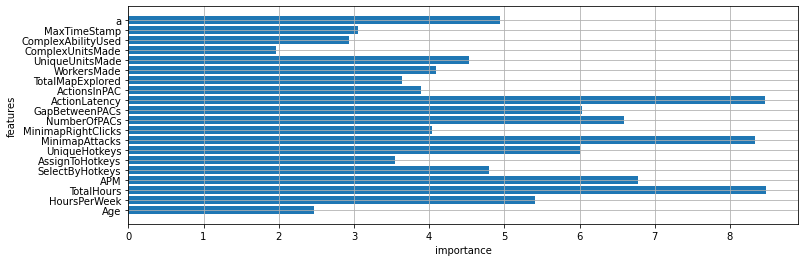

In [147]:

    # 特徴量の重要度を取得する
    feature_importance = catb_models[11].get_feature_importance()
    # 棒グラフとしてプロットする
    plt.figure(figsize=(12, 4))
    plt.barh(range(len(feature_importance)),
            feature_importance,
            tick_label=list(x))

    plt.xlabel('importance')
    plt.ylabel('features')
    plt.grid()
    plt.savefig('../result/catb_default_importance')
    plt.show()


In [173]:
test_x

In [175]:
import csv

y_pred = catb_models[14].predict(test_x)
y_pred_max = np.argmax(y_pred, axis=1)
with open("../result/catb_increase_feature.csv", "w") as csv_file:
    for pred_low, test_id in zip(y_pred_max, test_data['Unnamed: 0']):
        writer = csv.writer(csv_file)
        low = [test_id, int(pred_low+1)]
        writer.writerow(low)

    csv_file.close()